In [738]:
# Load Neccessary Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import caffe
import num_recog
reload(num_recog)

<module 'num_recog' from 'num_recog.pyc'>

In [739]:
# Load caffe model
caffe.set_mode_cpu()

net = caffe.Net('./model/lenet.prototxt',
                './model/mnist_iter_20000.caffemodel',
               caffe.TEST)


In [740]:
# Swap 2 objects
def swap(a,b):
    return b,a

def find_contour_bound(cont):
    left_bound = min(cont, key = lambda x: x[0])[0]
    right_bound = max(cont, key = lambda x: x[0])[0]
    lower_bound = min(cont, key = lambda x: x[1])[1]
    upper_bound = max(cont, key = lambda x: x[1])[1]
    return (left_bound, right_bound, lower_bound, upper_bound)

def sort_points(rect):
    x_sort = np.array(sorted(rect, key=lambda x: x[1]))
    if x_sort[0,0] > x_sort[1,0]:
        x_sort[0,0], x_sort[1,0] = swap(x_sort[0,0], x_sort[1,0])
    if x_sort[2,0] > x_sort[3,0]:
        x_sort[2,0], x_sort[3,0] = swap(x_sort[2,0], x_sort[3,0])  
    return x_sort
            
def filterRects(rect, pure_cont = False):
    if pure_cont:
        left_bound, right_bound, lower_bound, upper_bound = find_contour_bound(rect[:,0])
    else:
        left_bound, right_bound, lower_bound, upper_bound = find_contour_bound(rect)
    x = right_bound - left_bound
    y = float(upper_bound) - lower_bound
    if y / x >= 0.3 and y / x <= 0.6:
        return True
    return False

def get_size(cv2_img):
    return (len(cv2_img[0]), len(cv2_img)) #width, height

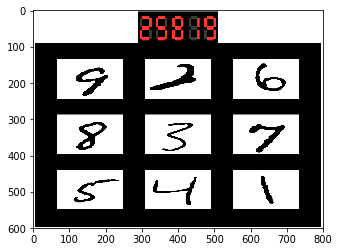

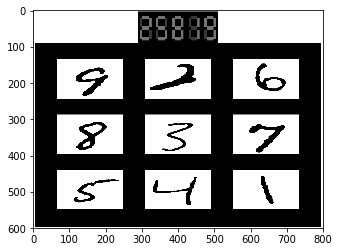

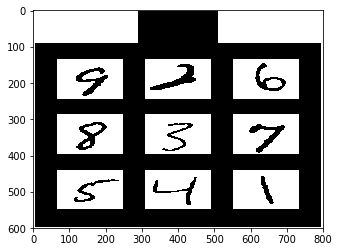

In [741]:
# Load image and compute its threshold binary map
img = cv2.imread('./test6.png')
img = cv2.resize(img, (800,600))
img_cp = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret3,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(gray, cmap='gray')
plt.show()
plt.imshow(thresh, cmap='gray')
plt.show()

In [742]:
# Find all contours
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# Filter out contours that are either too big or too small
width, height = get_size(img)
img_width_range = (0.125 * width, 0.3 * width)
img_height_range = (0.1 * height, 0.18 * height)
#contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= 100*40 and cv2.contourArea(cnt) <= 300*150]
contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= img_width_range[0] * img_height_range[0] and cv2.contourArea(cnt) <= img_width_range[1] * img_height_range[1] and filterRects(cnt, pure_cont = True)]
# Find contour approximation and enforce a 4-sided convex shape
tmp = []
for cnt in contours:
    epsilon = 0.05*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        tmp.append(approx)

print "this is len of contours " + str(len(contours))
print "This one is tmp " + str(len(tmp))
if len(tmp) == 8:
    print "Manually fixing..."
    tmp = []
    for cnt in contours:
        left, right, lower, upper = find_contour_bound(cnt[:,0])
        box = [[left, lower], [right, lower], [right, upper], [left, upper]]
        tmp.append(box)
    while len(tmp) > 9:
        tmp.remove(max(tmp, key = lambda x: x[2][1])) #remove highest contour
    contours = np.array(tmp)
else:
    contours = np.array(tmp)[:,:,0,:]

cv2.drawContours(img, contours, -1, (0,255,0), 3)

this is len of contours 9
This one is tmp 9


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

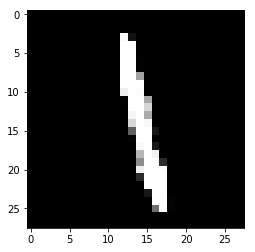

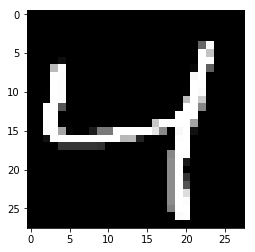

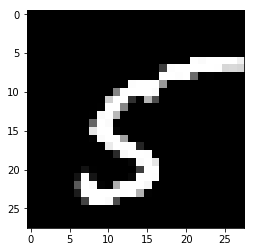

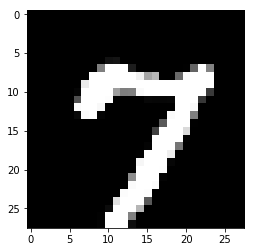

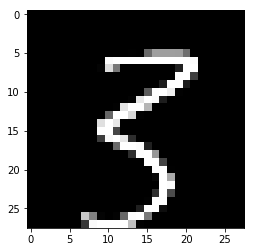

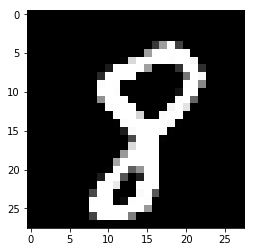

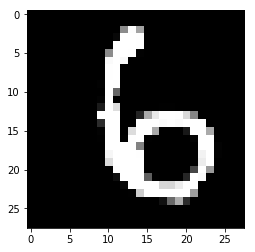

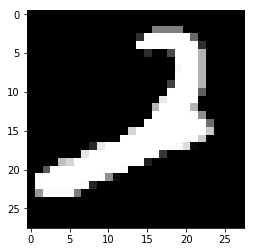

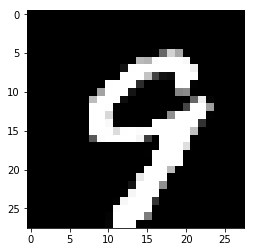

In [743]:
BOX_LEN = 32                # bounding box length for digits
offset = (BOX_LEN - 28) / 2 # calculated padding length
# Destination Points
dstpts = np.array([[0,0],[BOX_LEN,0],[0,BOX_LEN],[BOX_LEN,BOX_LEN]], dtype='float32')

bboxs = []
points = []

for cnt in contours:
    # Sort points with respect to relative location
    pts1 = sort_points(cnt).astype('float32')
    points.append(pts1)
    # Geometric transformation that project the 4-sided shape onto a 32x32 grid
    M = cv2.getPerspectiveTransform(pts1,dstpts)
    new_img = cv2.warpPerspective(gray,M,(BOX_LEN,BOX_LEN))
    new_img = 255 - new_img[offset:-offset, offset:-offset]
    bboxs.append(new_img)
    plt.imshow(bboxs[-1], cmap='gray')
    plt.show()

bboxs = np.array(bboxs)[:, None,...]

False


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


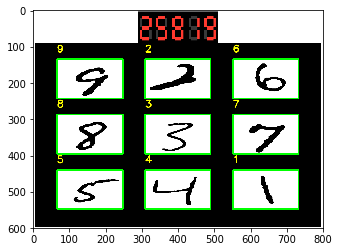

In [744]:
net.blobs['data'].reshape(bboxs.shape[0], 1, 28, 28)
net.blobs['data'].data[...] = bboxs.astype('float32') / 255
out = net.forward()
dig_ids = out['prob'].argmax(axis = 1)
a = out['prob']
print a == np.array([3,2,5,7,1,2,3,4])
for i in range(len(points)):
    cv2.putText(img, str(dig_ids[i]),
                (int(points[i][0,0]), int(points[i][0,1]-20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
               (0,255,255),
               2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

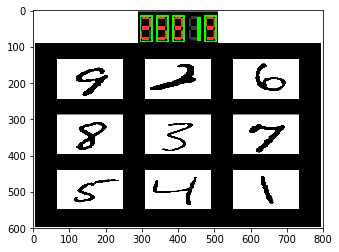

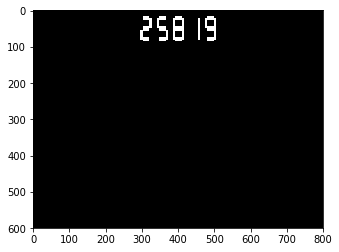

In [745]:
org_img = img_cp.copy()
hsv_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)
lower_red = np.array([0,120,90])
upper_red = np.array([10,255,255])
mask = cv2.inRange(hsv_img, lower_red, upper_red)
mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
lower_red = np.array([170,120,90])
upper_red = np.array([179,255,255])
mask2 = cv2.inRange(hsv_img, lower_red, upper_red)
mask = np.bitwise_or(mask1, mask2)

kernel = np.ones((5, 1), np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 1)

kernel1 = np.ones((9,9),np.uint8)
kernel2 = np.ones((6,6),np.uint8)
kernel3 = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel2)

y_min = min(contours,key=lambda cnt: cnt[0,1])[0,1]
y_min = int(y_min)
ftr = np.ones((600,800),np.uint8)
ftr[y_min:-1,:] = 0
mask = cv2.bitwise_and(mask, mask, mask=ftr)

im2, sct_cnts, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(cnt) for cnt in sct_cnts]
rects = sorted(rects, key=lambda x: x[0])

for rect in rects:
    cv2.rectangle(org_img, (rect[0], rect[1]),(rect[0]+rect[2], rect[1]+rect[3]),(0,255,0),3)

#mask = cv2.dilate(mask, kernel3)
res = cv2.bitwise_and(gray, gray, mask=mask)
plt.imshow(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

In [746]:
def pad_diggit(img):
    w, h = img.shape[1], img.shape[0]
    length = int(h * 1.4)
    v_pad = int((length - h) / 2)
    h_pad = int((length - w) / 2)
    new_img = cv2.copyMakeBorder(img, v_pad, v_pad, h_pad, h_pad, borderType=cv2.BORDER_CONSTANT, value=0)
    #new_img = cv2.resize(new_img, (8, 8))
    return cv2.resize(new_img, (28,28))

(9, 4, 10, 20)


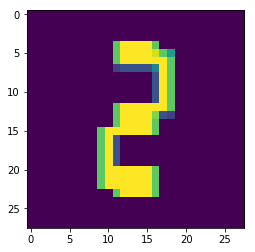

(9, 4, 10, 20)


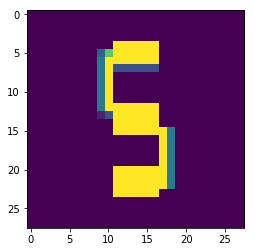

(9, 4, 10, 20)


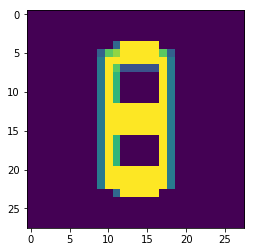

(13, 4, 2, 20)


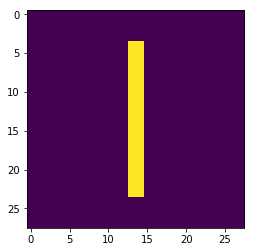

(9, 4, 10, 20)


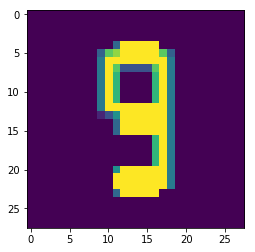

In [747]:
for rect in rects:
    x, y, w, h = rect[0], rect[1], rect[2], rect[3]
    crop = mask[y:y+h, x:x+w]
    #plt.imshow(pad_diggit(crop), cmap='gray')
    #plt.show()
    #print(pad_diggit(crop))
    #print(pad_diggit(crop).mean(axis=0).mean())
rect = rects[0]
for rect in rects:
    x, y, w, h = rect[0], rect[1], rect[2], rect[3]
    crop = mask[y:y+h, x:x+w]
    aa = pad_diggit(crop)
    x, y, w, h = cv2.boundingRect(aa)
    print (x,y,w,h)
    #cv2.rectangle(aa, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(aa)
    plt.show()

In [748]:
for rect in rects:
    print mask[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]].mean()
    print num_recog.digit_recognition(pad_diggit(mask[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]))

122.491071429
[0, 1, 1, 0, 1, 1, 1]
2
124.32718894
[1, 0, 0, 1, 1, 1, 1]
5
173.564516129
[1, 1, 1, 1, 1, 1, 1]
8
255.0
-1
151.119815668
[1, 0, 1, 1, 1, 1, 1]
9


In [749]:
secrets = np.array([pad_diggit(mask[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]) for rect in rects], dtype='float32')
secrets = secrets[:,None,...].astype('float32') / 255
net.blobs['data'].reshape(secrets.shape[0], 1, 28, 28)
net.blobs['data'].data[...] = secrets
out = net.forward()
dig_ids = out['prob'].argmax(axis = 1)
print dig_ids

[2 5 8 1 9]
